# Digital Image Processing - Open Ended Lab (OEL)
## Automated Melanoma Detection and Classification using PH2 Dataset

**Project Overview**
This project aims to develop an automated system for the analysis of dermoscopic images from the PH2 dataset. The project is divided into two main parts:

**Part 1: Lesion Segmentation**
- Preprocessing: Image enhancement and artifact removal (hair removal).
- Segmentation: Generating a binary mask of the skin lesion.
- Evaluation: Comparing the generated masks with ground truth masks using Accuracy, Sensitivity, Specificity, and Dice Coefficient.

**Part 2: Lesion Classification**
- Feature Extraction: Extracting color and texture features from the segmented lesions.
- Classification: Using Machine Learning models (SVM, Random Forest, KNN) to classify lesions into Common Nevus (0) or Atypical Nevus/Melanoma (1).


In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler

# Configure plotting
plt.rcParams['figure.figsize'] = (12, 8)
plt.style.use('ggplot')

ModuleNotFoundError: No module named 'pandas'

### 1. Configuration and Paths
Defining the paths for the dataset, output masks, and feature file.

In [2]:
# Define Paths
BASE_DIR = os.getcwd()
DATASET_ROOT = os.path.join(BASE_DIR, 'data', 'PH2Dataset', 'PH2 Dataset images')
EXCEL_PATH = os.path.join(BASE_DIR, 'data', 'PH2Dataset', 'PH2_dataset.xlsx')
OUTPUT_MASK_DIR = os.path.join(BASE_DIR, 'Output_Masks')
OUTPUT_CSV_PATH = os.path.join(BASE_DIR, 'extracted_features.csv')

# Create output directory
if not os.path.exists(OUTPUT_MASK_DIR):
    os.makedirs(OUTPUT_MASK_DIR)
    print(f"Created directory: {OUTPUT_MASK_DIR}")

if not os.path.exists(DATASET_ROOT):
    print(f"WARNING: Dataset root not found at {DATASET_ROOT}")
else:
    print(f"Dataset root found: {DATASET_ROOT}")

Dataset root found: d:\Desktop\Projects\DIP_OEL_PH2\data\PH2Dataset\PH2 Dataset images


### 2. Segmentation Functions
Algorithms for hair removal, preprocessing, segmentation (Otsu), and post-processing.

In [3]:
def remove_hair(image):
    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Kernel for morphology
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (17, 17))
    
    # BlackHat transform to find dark hair on light skin
    blackhat = cv2.morphologyEx(gray, cv2.MORPH_BLACKHAT, kernel)
    
    # Thresholding to extract hair mask
    _, thresh = cv2.threshold(blackhat, 10, 255, cv2.THRESH_BINARY)
    
    # Inpaint to remove hair
    dst = cv2.inpaint(image, thresh, 1, cv2.INPAINT_TELEA)
    return dst

def segment_lesion(image):
    # 1. Remove Hair
    clean_image = remove_hair(image)
    
    # 2. Extract Blue Channel (good contrast for brown/black lesions)
    b, g, r = cv2.split(clean_image)
    
    # 3. Apply Gaussian Blur
    blur = cv2.GaussianBlur(b, (5, 5), 0)
    
    # 4. Otsu's Thresholding (Inverse because lesion is dark)
    _, mask = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    
    # 5. Post-processing: Morphological Operations
    kernel = np.ones((5, 5), np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel, iterations=2)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel, iterations=2)
    
    # 6. Keep only the largest connected component (the lesion)
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(mask, connectivity=8)
    if num_labels > 1:
        # Find largest component ignoring background (label 0)
        largest_label = 1 + np.argmax(stats[1:, cv2.CC_STAT_AREA])
        mask = np.zeros_like(mask)
        mask[labels == largest_label] = 255
        
    return mask, clean_image

def evaluate_mask(pred_mask, true_mask):
    # Flatten arrays
    y_pred = pred_mask.flatten() // 255
    y_true = true_mask.flatten() // 255
    
    # Confusion Matrix
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred, labels=[0, 1]).ravel()
    
    # Metrics
    accuracy = (tp + tn) / (tp + tn + fp + fn) if (tp + tn + fp + fn) > 0 else 0
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0 # Recall
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    dice = (2 * tp) / (2 * tp + fp + fn) if (2 * tp + fp + fn) > 0 else 0
    
    return accuracy, sensitivity, specificity, dice

### 3. Processing Loop
Iterate through all images in the dataset, generate masks, save them, and calculate evaluation metrics.

Found 200 images. Starting processing...


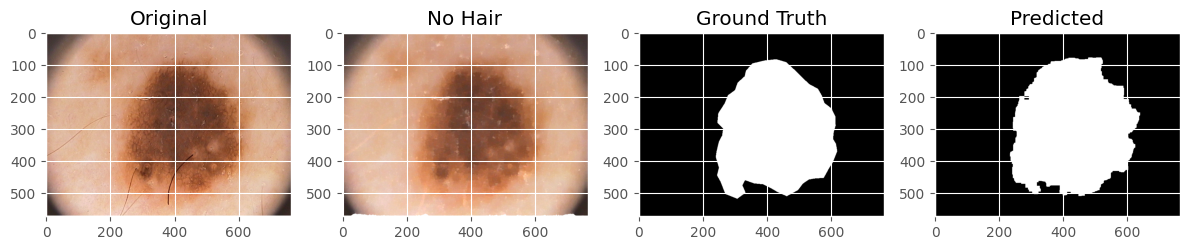

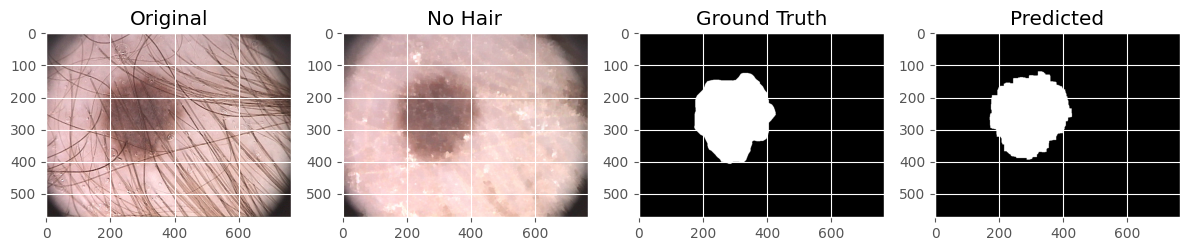

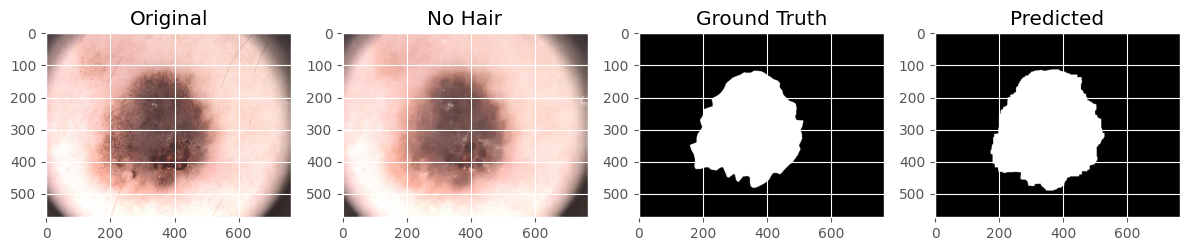

Processed 20/200
Processed 40/200
Processed 60/200
Processed 80/200
Processed 100/200
Processed 120/200
Processed 140/200
Processed 160/200
Processed 180/200
Processed 200/200
Processing Complete.
Average Metrics:
Accuracy       0.921469
Sensitivity    0.848359
Specificity    0.952983
Dice           0.873165
dtype: float64


In [4]:
results = []
generated_masks = {} # Store for Part 2
BASE_DIR = globals().get('BASE_DIR', os.getcwd())
DATASET_ROOT = globals().get('DATASET_ROOT', os.path.join(BASE_DIR, 'data', 'PH2Dataset', 'PH2 Dataset images'))
OUTPUT_MASK_DIR = globals().get('OUTPUT_MASK_DIR', os.path.join(BASE_DIR, 'Output_Masks'))
os.makedirs(OUTPUT_MASK_DIR, exist_ok=True)

if os.path.exists(DATASET_ROOT):
    # Get all subdirectories
    img_folders = sorted([f for f in os.listdir(DATASET_ROOT) if os.path.isdir(os.path.join(DATASET_ROOT, f))])
    img_folders = [f for f in img_folders if f.startswith('IMD')] # Filter
    
    print(f"Found {len(img_folders)} images. Starting processing...")
    
    for i, img_id in enumerate(img_folders):
        # Construct paths
        img_path = os.path.join(DATASET_ROOT, img_id, f"{img_id}_Dermoscopic_Image", f"{img_id}.bmp")
        gt_path = os.path.join(DATASET_ROOT, img_id, f"{img_id}_lesion", f"{img_id}_lesion.bmp")
        
        if not os.path.exists(img_path) or not os.path.exists(gt_path):
            continue
            
        # Read Image
        original_img = cv2.imread(img_path)
        gt_mask = cv2.imread(gt_path, cv2.IMREAD_GRAYSCALE)
        
        if original_img is None or gt_mask is None:
            continue
        
        # Generate Mask
        pred_mask, clean_img = segment_lesion(original_img)
        
        # Save Mask
        save_path = os.path.join(OUTPUT_MASK_DIR, f"{img_id}_mask.png")
        cv2.imwrite(save_path, pred_mask)
        
        # Store for Part 2
        generated_masks[img_id] = {
            'mask': pred_mask,
            'clean_image': clean_img
        }
        
        # Evaluate
        if pred_mask.shape != gt_mask.shape:
            pred_mask = cv2.resize(pred_mask, (gt_mask.shape[1], gt_mask.shape[0]), interpolation=cv2.INTER_NEAREST)
            
        acc, sens, spec, dice = evaluate_mask(pred_mask, gt_mask)
        
        results.append({
            'Image_ID': img_id,
            'Accuracy': acc,
            'Sensitivity': sens,
            'Specificity': spec,
            'Dice': dice
        })
        if i < 3:
            plt.figure(figsize=(12, 3))
            plt.subplot(141)
            plt.imshow(cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB))
            plt.title('Original')
            plt.subplot(142)
            plt.imshow(cv2.cvtColor(clean_img, cv2.COLOR_BGR2RGB))
            plt.title('No Hair')
            plt.subplot(143)
            plt.imshow(gt_mask, cmap='gray')
            plt.title('Ground Truth')
            plt.subplot(144)
            plt.imshow(pred_mask, cmap='gray')
            plt.title('Predicted')
            plt.tight_layout()
            plt.show()
        
        if (i + 1) % 20 == 0:
            print(f"Processed {i + 1}/{len(img_folders)}")

    # Create DataFrame
    df_segmentation = pd.DataFrame(results)
    print("Processing Complete.")
    print("Average Metrics:")
    print(df_segmentation.mean(numeric_only=True))
else:
    print("Dataset root not found.")

### 4. Feature Extraction
Extracting Color (Mean, Std) and Shape (Area, Perimeter, Circularity) features.

In [5]:
def extract_features(image, mask):
    features = {}
    
    # Ensure mask is binary
    _, bin_mask = cv2.threshold(mask, 127, 255, cv2.THRESH_BINARY)
    
    # 1. Color Features (in RGB)
    mean_val = cv2.mean(image, mask=bin_mask)
    features['Mean_B'] = mean_val[0]
    features['Mean_G'] = mean_val[1]
    features['Mean_R'] = mean_val[2]
    
    # Std Dev
    masked_pixels = image[bin_mask == 255]
    if masked_pixels.size > 0:
        std_b = np.std(masked_pixels[:, 0])
        std_g = np.std(masked_pixels[:, 1])
        std_r = np.std(masked_pixels[:, 2])
    else:
        std_b, std_g, std_r = 0, 0, 0
        
    features['Std_B'] = std_b
    features['Std_G'] = std_g
    features['Std_R'] = std_r
    
    # 2. Shape Features
    contours, _ = cv2.findContours(bin_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if contours:
        cnt = max(contours, key=cv2.contourArea)
        area = cv2.contourArea(cnt)
        perimeter = cv2.arcLength(cnt, True)
        if perimeter > 0:
            circularity = (4 * np.pi * area) / (perimeter ** 2)
        else:
            circularity = 0
    else:
        area, perimeter, circularity = 0, 0, 0
        
    features['Area'] = area
    features['Perimeter'] = perimeter
    features['Circularity'] = circularity
    
    return features

# Extract features loop
feature_list = []
if generated_masks:
    print("Extracting features...")
    for img_id, data in generated_masks.items():
        feats = extract_features(data['clean_image'], data['mask'])
        feats['Image_ID'] = img_id
        feature_list.append(feats)
        
    df_features = pd.DataFrame(feature_list)
    df_features.to_csv(OUTPUT_CSV_PATH, index=False)
    print(f"Features saved to: {OUTPUT_CSV_PATH}")

Extracting features...
Features saved to: d:\Desktop\Projects\DIP_OEL_PH2\extracted_features.csv


### 5. Load Ground Truth Labels
Reading the PH2 dataset Excel file to get diagnosis labels (Common Nevus vs Atypical/Melanoma).

In [ ]:
%pip install openpyxl

In [8]:
BASE_DIR = globals().get('BASE_DIR', os.getcwd())
EXCEL_PATH = globals().get('EXCEL_PATH', os.path.join(BASE_DIR, 'data', 'PH2Dataset', 'PH2_dataset.xlsx'))
if os.path.exists(EXCEL_PATH):
    try:
        # Load Excel, header is typically at row 12
        df_labels = pd.read_excel(EXCEL_PATH, header=12)
        
        # Clean column names
        df_labels.columns = [str(c).strip() for c in df_labels.columns]
        
        if 'Image Name' in df_labels.columns:
            df_labels.rename(columns={'Image Name': 'Image_ID'}, inplace=True)
            
            # Logic to extract target from 'X' markers
            def get_label(row):
                if 'Common Nevus' in row and str(row['Common Nevus']).strip().upper() == 'X':
                    return 0
                if 'Atypical Nevus' in row and str(row['Atypical Nevus']).strip().upper() == 'X':
                    return 1
                if 'Melanoma' in row and str(row['Melanoma']).strip().upper() == 'X':
                    return 1
                return 1 # Default conservative
            
            df_labels['Target'] = df_labels.apply(get_label, axis=1)
            
            # Merge with features
            df_merged = pd.merge(df_features, df_labels[['Image_ID', 'Target']], on='Image_ID')
            print(f"Merged Data Shape: {df_merged.shape}")
            print("Class distribution:\n", df_merged['Target'].value_counts())
        else:
            print("'Image Name' column not found in Excel.")
            df_merged = pd.DataFrame()
    except Exception as e:
        print(f"Error reading Excel: {e}")
        df_merged = pd.DataFrame()
else:
    print("Excel file not found.")
    df_merged = pd.DataFrame()

Merged Data Shape: (200, 11)
Class distribution:
 Target
1    120
0     80
Name: count, dtype: int64


### 6. Classification
Training SVM, Random Forest, and KNN models (80/20 split).


--- SVM ---
Accuracy: 0.7250
Sensitivity: 0.7917
Specificity: 0.6250
Confusion Matrix:
[[10  6]
 [ 5 19]]
              precision    recall  f1-score   support

           0       0.67      0.62      0.65        16
           1       0.76      0.79      0.78        24

    accuracy                           0.72        40
   macro avg       0.71      0.71      0.71        40
weighted avg       0.72      0.72      0.72        40


--- Random Forest ---
Accuracy: 0.7250
Sensitivity: 0.7917
Specificity: 0.6250
Confusion Matrix:
[[10  6]
 [ 5 19]]
              precision    recall  f1-score   support

           0       0.67      0.62      0.65        16
           1       0.76      0.79      0.78        24

    accuracy                           0.72        40
   macro avg       0.71      0.71      0.71        40
weighted avg       0.72      0.72      0.72        40


--- KNN ---
Accuracy: 0.7000
Sensitivity: 0.7083
Specificity: 0.6875
Confusion Matrix:
[[11  5]
 [ 7 17]]
              p

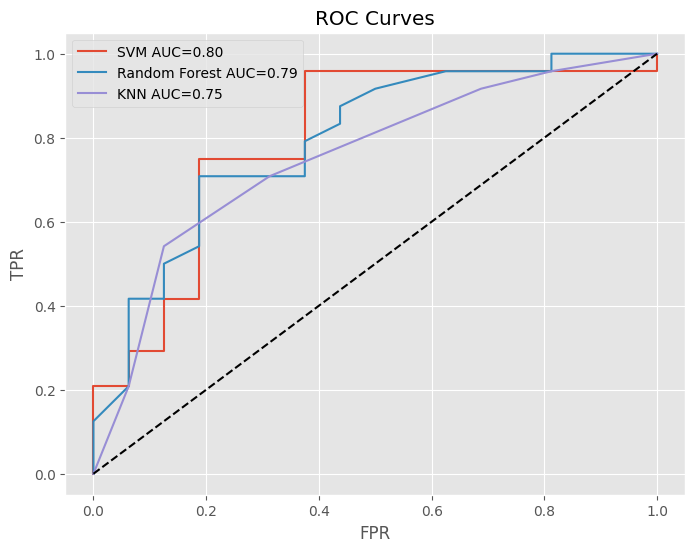

In [9]:
df_merged = globals().get('df_merged', pd.DataFrame())
if not df_merged.empty and len(df_merged) > 5:
    # Prepare Data
    X = df_merged.drop(['Image_ID', 'Target'], axis=1, errors='ignore')
    # Drop non-numeric if any
    X = X.select_dtypes(include=[np.number])
    y = df_merged['Target']
    
    # Split 80-20
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    
    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Define Models
    models = {
        "SVM": SVC(kernel='rbf', probability=True),
        "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
        "KNN": KNeighborsClassifier(n_neighbors=5)
    }
    from sklearn.metrics import roc_curve, auc
    plt.figure(figsize=(8, 6))
    
    # Train and Evaluate
    for name, model in models.items():
        print(f"\n--- {name} ---")
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
        
        # Metrics
        cm = confusion_matrix(y_test, y_pred, labels=[0, 1])
        tn, fp, fn, tp = cm.ravel()
        
        acc = accuracy_score(y_test, y_pred)
        sens = tp / (tp + fn) if (tp + fn) > 0 else 0
        spec = tn / (tn + fp) if (tn + fp) > 0 else 0
        
        print(f"Accuracy: {acc:.4f}")
        print(f"Sensitivity: {sens:.4f}")
        print(f"Specificity: {spec:.4f}")
        print("Confusion Matrix:")
        print(cm)
        print(classification_report(y_test, y_pred))
        y_proba = model.predict_proba(X_test_scaled)[:, 1] if hasattr(model, 'predict_proba') else None
        if y_proba is not None:
            fpr, tpr, _ = roc_curve(y_test, y_proba)
            plt.plot(fpr, tpr, label=f"{name} AUC={auc(fpr, tpr):.2f}")
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title('ROC Curves')
    plt.legend()
    plt.show()
else:
    print("Not enough data for classification.")